In [ ]:
# VGG16 customized --> 16 layers and 5 building blocks
# https://www.youtube.com/watch?v=mjk4vDYOwq0
# https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [ ]:
# pip install
# pip install -U tensorflow-addons
# !pip install -q "tqdm>=4.36.1"

In [1]:
from __future__ import print_function

import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, path
import cv2
from PIL import Image

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    roc_auc_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
)

from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

from tensorflow import compat as tf
import tensorflow as tf
import keras
import tensorflow
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input

import tqdm
import tensorflow_addons as tfa
import time

import config

In [2]:
# Set path for data
DATA_PATH_ABS: str = config.settings.DATA_PATH_ABS_TOBACCO_DATASET

# set random seed for purposes of reproducibility
seed = 21

In [3]:
# check versions of packages
print(keras.__version__)

2.9.0


In [4]:
# check versions of packages
print(tqdm.__version__)

4.64.0


In [ ]:
#########################################
# create model
#########################################

In [2]:
# create function to create model


def VGGupdated(input_tensor=None, classes=10):  # in our case probabaly six classes

    img_rows, img_cols = 300, 300  # by default its 224,224 --> can also change that
    img_channels = 3  # colored pictures

    img_dim = (img_rows, img_cols, img_channels)
    img_input = Input(shape=img_dim)

    # Block 1 # relu replace all negative values with 0, padding same means that output image has smimilar size to input image
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv1")(
        img_input
    )  # 64 is number of filter, 3x3 is size of filter
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="block1_conv2")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(
        x
    )  # reduce image size, stride means how much we want to jump horizontally and vertically

    # Block 2
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv1")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="block2_conv2")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv1")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv2")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="block3_conv3")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv1")(x)
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv2")(x)
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block4_conv3")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv1")(x)
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv2")(x)
    x = Conv2D(512, (3, 3), activation="relu", padding="same", name="block5_conv3")(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name="block5_pool")(x)

    # Classification block
    x = Flatten(name="flatten")(x)
    x = Dense(4096, activation="relu", name="fc1")(x)  # fully connected layers, 4096 number of neurons
    x = Dense(4096, activation="relu", name="fc2")(x)
    x = Dense(classes, activation="softmax", name="predictio")(x)

    # Create model

    model = Model(inputs=img_input, outputs=x, name="VGGmodel")

    return model

In [3]:
# create the model
model = VGGupdated(classes=10)

2022-08-10 11:07:36.152889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 11:07:36.154378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 11:07:36.162684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/thenn/.local/share/virtualenvs/dssgxdfki2022-occrp-CY4k_1kg/lib64/python3.8/site-packages/cv2/../../lib64:
2022-08-10 11:07:36.162708: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you wou

In [7]:
# compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [4]:
# model summary
model.summary()

Model: "VGGmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0  

In [ ]:
#########################################
# load and transform data
#########################################

In [9]:
# Load tabacco data

doc_types = os.listdir(DATA_PATH_ABS)
print("Types of document types:", *doc_types, sep=" ")  # what kinds of documents do we have
print("Types of documents founds:", len(doc_types))
print(doc_types)

# if you need to remove DS_Store file: rm -f .DS_Store

FileNotFoundError: [Errno 2] No such file or directory: '/data/dssg/occrp/data/input/tobacco_dataset/'

In [8]:
# load data
documents = []

for item in doc_types:
    # get all the file names
    all_documents = os.listdir(DATA_PATH_ABS + item)
    # print(all_documents)

    # add them to the list
    for document in all_documents:
        documents.append((item, str(DATA_PATH_ABS + item) + "/" + document))
        # print(documents)

In [9]:
# build dataframe
documents_df = pd.DataFrame(data=documents, columns=["document_type", "image"])
print(documents_df.head())

  document_type                               image
0          Note  Tobacco3482/Note/70057287-7287.jpg
1          Note       Tobacco3482/Note/50076168.jpg
2          Note    Tobacco3482/Note/2074071502a.jpg
3          Note     Tobacco3482/Note/2044183733.jpg
4          Note       Tobacco3482/Note/60019614.jpg


In [10]:
# check how many samples for each category
print("Total number of documents in the dataset: ", len(documents_df))
documents_count = documents_df["document_type"].value_counts()
print("Documents in each category: ")
print(documents_count)

Total number of documents in the dataset:  3482
Documents in each category: 
Memo          620
Email         599
Letter        567
Form          431
Report        265
Scientific    261
ADVE          230
Note          201
News          188
Resume        120
Name: document_type, dtype: int64


In [11]:
# resize images

im_size = 300

images = []
labels = []
broken = []

for i in doc_types:
    doc_list = DATA_PATH_ABS + str(i)
    filenames = [i for i in os.listdir(doc_list)]

    for f in filenames:
        try:
            img = cv2.imread(doc_list + "/" + f)
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(i)
        except Exception:
            broken.append(f)
            # labels.drop(i)

In [12]:
# check for broken images and remove them from folder
broken

[]

In [13]:
# transform to numpy array
images = np.array(images)
images = images.astype("float32") / 255.0  # 255 maximum number of pixels

images.shape

(3482, 300, 300, 3)

In [14]:
# transform labels into numbers
y = documents_df["document_type"].values
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)

[6 6 6 ... 9 9 9]


In [15]:
# transform numbers into one hot encoding
y = y.reshape(-1, 1)
onehotencoder = OneHotEncoder(categories="auto", sparse=False)
Y = onehotencoder.fit_transform(y)

Y.shape

(3482, 10)

In [16]:
# shuffle and split training data

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=415)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2785, 300, 300, 3)
(2785, 10)
(697, 300, 300, 3)
(697, 10)


In [ ]:
#########################################
# fit the model
#########################################

In [18]:
# create tensorflow board
PATH_LOGS = os.path.join(
    os.getcwd(),
    config.settings.DATA_FOLDER_LOGS,
)


def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(PATH_LOGS, run_id)


run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [21]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()  # tensorboard_cb
np.random.seed(seed)  # random seed for reproducability
# fit the model
history = model.fit(
    train_x,
    train_y,
    validation_split=0.3,
    epochs=7,
    batch_size=32,
    callbacks=[tqdm_callback],
    verbose=1,
)

Training:   0%|           0/7 ETA: ?s,  ?epochs/s

Epoch 1/7


Epoch 1/7


 1/61 [..............................] - ETA: 34:38 - loss: 2.3028 - accuracy: 0.0312

 2/61 [..............................] - ETA: 26:12 - loss: 2.3030 - accuracy: 0.0156

 3/61 [>.............................] - ETA: 25:08 - loss: 2.3030 - accuracy: 0.0104

 4/61 [>.............................] - ETA: 24:29 - loss: 2.3029 - accuracy: 0.0156

 5/61 [=>............................] - ETA: 24:03 - loss: 2.3029 - accuracy: 0.0312

 6/61 [=>............................] - ETA: 23:40 - loss: 2.3028 - accuracy: 0.0365

 7/61 [==>...........................] - ETA: 23:16 - loss: 2.3028 - accuracy: 0.0357

 8/61 [==>...........................] - ETA: 22:56 - loss: 2.3027 - accuracy: 0.0430

 9/61 [===>..........................] - ETA: 22:32 - loss: 2.3027 - accuracy: 0.0417

10/61 [===>..........................] - ETA: 21:59 - loss: 2.3027 - accuracy: 0.0375

11/61 [====>.........................] - ETA: 21:29 - loss: 2.3026 - accuracy: 0.0511

12/61 [====>.........................] - ETA: 20:56 - loss: 2.3025 - accuracy: 0.0573

13/61 [=====>........................] - ETA: 20:33 - loss: 2.3026 - accuracy: 0.0625

14/61 [=====>........................] - ETA: 20:05 - loss: 2.3025 - accuracy: 0.0670

15/61 [======>.......................] - ETA: 19:37 - loss: 2.3024 - accuracy: 0.0854

16/61 [======>.......................] - ETA: 19:09 - loss: 2.3024 - accuracy: 0.0918

17/61 [=======>......................] - ETA: 18:41 - loss: 2.3023 - accuracy: 0.0956

18/61 [=======>......................] - ETA: 18:28 - loss: 2.3023 - accuracy: 0.0955

19/61 [========>.....................] - ETA: 18:03 - loss: 2.3022 - accuracy: 0.0987

20/61 [========>.....................] - ETA: 17:40 - loss: 2.3022 - accuracy: 0.1047

21/61 [=========>....................] - ETA: 17:14 - loss: 2.3022 - accuracy: 0.1146

22/61 [=========>....................] - ETA: 16:48 - loss: 2.3021 - accuracy: 0.1250

23/61 [==========>...................] - ETA: 16:22 - loss: 2.3021 - accuracy: 0.1332

24/61 [==========>...................] - ETA: 15:56 - loss: 2.3020 - accuracy: 0.1445

25/61 [===========>..................] - ETA: 15:30 - loss: 2.3020 - accuracy: 0.1513

26/61 [===========>..................] - ETA: 15:02 - loss: 2.3019 - accuracy: 0.1550

27/61 [============>.................] - ETA: 14:36 - loss: 2.3019 - accuracy: 0.1574

28/61 [============>.................] - ETA: 14:10 - loss: 2.3018 - accuracy: 0.1574

29/61 [=============>................] - ETA: 13:44 - loss: 2.3018 - accuracy: 0.1595

30/61 [=============>................] - ETA: 13:18 - loss: 2.3018 - accuracy: 0.1635

31/61 [==============>...............] - ETA: 12:52 - loss: 2.3017 - accuracy: 0.1663

32/61 [==============>...............] - ETA: 12:28 - loss: 2.3017 - accuracy: 0.1670

33/61 [===============>..............] - ETA: 12:01 - loss: 2.3017 - accuracy: 0.1723

34/61 [===============>..............] - ETA: 11:35 - loss: 2.3017 - accuracy: 0.1737

35/61 [================>.............] - ETA: 11:09 - loss: 2.3016 - accuracy: 0.1750

36/61 [================>.............] - ETA: 10:43 - loss: 2.3015 - accuracy: 0.1727

37/61 [=================>............] - ETA: 10:18 - loss: 2.3015 - accuracy: 0.1715

38/61 [=================>............] - ETA: 9:52 - loss: 2.3015 - accuracy: 0.1702 

39/61 [==================>...........] - ETA: 9:26 - loss: 2.3014 - accuracy: 0.1691

40/61 [==================>...........] - ETA: 9:00 - loss: 2.3014 - accuracy: 0.1695

41/61 [===================>..........] - ETA: 8:34 - loss: 2.3014 - accuracy: 0.1684

42/61 [===================>..........] - ETA: 8:08 - loss: 2.3013 - accuracy: 0.1674

43/61 [====================>.........] - ETA: 7:43 - loss: 2.3013 - accuracy: 0.1708

44/61 [====================>.........] - ETA: 7:17 - loss: 2.3012 - accuracy: 0.1761

45/61 [=====================>........] - ETA: 6:52 - loss: 2.3012 - accuracy: 0.1771

46/61 [=====================>........] - ETA: 6:25 - loss: 2.3012 - accuracy: 0.1793

47/61 [======================>.......] - ETA: 5:59 - loss: 2.3011 - accuracy: 0.1802

48/61 [======================>.......] - ETA: 5:34 - loss: 2.3011 - accuracy: 0.1816

49/61 [=======================>......] - ETA: 5:08 - loss: 2.3010 - accuracy: 0.1837

50/61 [=======================>......] - ETA: 4:42 - loss: 2.3010 - accuracy: 0.1838

51/61 [========================>.....] - ETA: 4:16 - loss: 2.3010 - accuracy: 0.1820

52/61 [========================>.....] - ETA: 3:51 - loss: 2.3009 - accuracy: 0.1839

53/61 [=========================>....] - ETA: 3:25 - loss: 2.3009 - accuracy: 0.1851

54/61 [=========================>....] - ETA: 2:59 - loss: 2.3008 - accuracy: 0.1840

55/61 [==========================>...] - ETA: 2:34 - loss: 2.3008 - accuracy: 0.1830

56/61 [==========================>...] - ETA: 2:08 - loss: 2.3007 - accuracy: 0.1836

57/61 [===========================>..] - ETA: 1:42 - loss: 2.3007 - accuracy: 0.1820

58/61 [===========================>..] - ETA: 1:17 - loss: 2.3006 - accuracy: 0.1827

59/61 [============================>.] - ETA: 51s - loss: 2.3005 - accuracy: 0.1838 

60/61 [============================>.] - ETA: 25s - loss: 2.3004 - accuracy: 0.1844

61/61 [==============================] - ETA: 0s - loss: 2.3004 - accuracy: 0.1842 

61/61██████████ ETA: 00:00s - loss: 2.3004 - accuracy: 0.1842 - val_loss: 2.2984 - val_accuracy: 0.1818
Training:  14%|█▍         1/7 ETA: 2:55:15s,  1752.52s/epochs

61/61 [==============================] - 1752s 29s/step - loss: 2.3004 - accuracy: 0.1842 - val_loss: 2.2984 - val_accuracy: 0.1818
Epoch 2/7


Epoch 2/7


 1/61 [..............................] - ETA: 27:19 - loss: 2.2968 - accuracy: 0.1875

 2/61 [..............................] - ETA: 25:09 - loss: 2.2960 - accuracy: 0.1875

 3/61 [>.............................] - ETA: 24:44 - loss: 2.2962 - accuracy: 0.1979

 4/61 [>.............................] - ETA: 24:19 - loss: 2.2962 - accuracy: 0.2109

 5/61 [=>............................] - ETA: 23:52 - loss: 2.2961 - accuracy: 0.2125

 6/61 [=>............................] - ETA: 23:25 - loss: 2.2967 - accuracy: 0.1927

 7/61 [==>...........................] - ETA: 22:50 - loss: 2.2974 - accuracy: 0.1830

 8/61 [==>...........................] - ETA: 22:26 - loss: 2.2974 - accuracy: 0.1797

 9/61 [===>..........................] - ETA: 22:05 - loss: 2.2975 - accuracy: 0.1701

10/61 [===>..........................] - ETA: 21:54 - loss: 2.2974 - accuracy: 0.1750

11/61 [====>.........................] - ETA: 21:59 - loss: 2.2974 - accuracy: 0.1761

12/61 [====>.........................] - ETA: 21:29 - loss: 2.2972 - accuracy: 0.1667

13/61 [=====>........................] - ETA: 20:57 - loss: 2.2972 - accuracy: 0.1707

14/61 [=====>........................] - ETA: 20:27 - loss: 2.2973 - accuracy: 0.1719

15/61 [======>.......................] - ETA: 19:58 - loss: 2.2971 - accuracy: 0.1792

16/61 [======>.......................] - ETA: 19:29 - loss: 2.2969 - accuracy: 0.1934

17/61 [=======>......................] - ETA: 18:59 - loss: 2.2968 - accuracy: 0.1912

18/61 [=======>......................] - ETA: 18:31 - loss: 2.2967 - accuracy: 0.1944

19/61 [========>.....................] - ETA: 18:04 - loss: 2.2967 - accuracy: 0.1908

20/61 [========>.....................] - ETA: 17:37 - loss: 2.2966 - accuracy: 0.1937

21/61 [=========>....................] - ETA: 17:10 - loss: 2.2965 - accuracy: 0.1890

22/61 [=========>....................] - ETA: 16:45 - loss: 2.2964 - accuracy: 0.1918

23/61 [==========>...................] - ETA: 16:19 - loss: 2.2964 - accuracy: 0.1902

24/61 [==========>...................] - ETA: 15:53 - loss: 2.2964 - accuracy: 0.1875

25/61 [===========>..................] - ETA: 15:26 - loss: 2.2965 - accuracy: 0.1875

26/61 [===========>..................] - ETA: 15:00 - loss: 2.2965 - accuracy: 0.1887

27/61 [============>.................] - ETA: 14:33 - loss: 2.2967 - accuracy: 0.1840

28/61 [============>.................] - ETA: 14:08 - loss: 2.2967 - accuracy: 0.1830

29/61 [=============>................] - ETA: 13:44 - loss: 2.2966 - accuracy: 0.1821

30/61 [=============>................] - ETA: 13:18 - loss: 2.2966 - accuracy: 0.1813

31/61 [==============>...............] - ETA: 12:52 - loss: 2.2966 - accuracy: 0.1815

32/61 [==============>...............] - ETA: 12:26 - loss: 2.2966 - accuracy: 0.1797

33/61 [===============>..............] - ETA: 12:00 - loss: 2.2966 - accuracy: 0.1780

34/61 [===============>..............] - ETA: 11:36 - loss: 2.2966 - accuracy: 0.1811

35/61 [================>.............] - ETA: 11:10 - loss: 2.2967 - accuracy: 0.1795

36/61 [================>.............] - ETA: 10:45 - loss: 2.2966 - accuracy: 0.1780

37/61 [=================>............] - ETA: 10:19 - loss: 2.2964 - accuracy: 0.1774

38/61 [=================>............] - ETA: 9:53 - loss: 2.2965 - accuracy: 0.1776 

39/61 [==================>...........] - ETA: 9:27 - loss: 2.2965 - accuracy: 0.1747

40/61 [==================>...........] - ETA: 9:02 - loss: 2.2965 - accuracy: 0.1758

41/61 [===================>..........] - ETA: 8:36 - loss: 2.2964 - accuracy: 0.1768

42/61 [===================>..........] - ETA: 8:10 - loss: 2.2964 - accuracy: 0.1786

43/61 [====================>.........] - ETA: 7:44 - loss: 2.2963 - accuracy: 0.1766

44/61 [====================>.........] - ETA: 7:18 - loss: 2.2963 - accuracy: 0.1747

45/61 [=====================>........] - ETA: 6:52 - loss: 2.2962 - accuracy: 0.1757

46/61 [=====================>........] - ETA: 6:26 - loss: 2.2961 - accuracy: 0.1766

47/61 [======================>.......] - ETA: 6:00 - loss: 2.2962 - accuracy: 0.1749

48/61 [======================>.......] - ETA: 5:35 - loss: 2.2961 - accuracy: 0.1758

49/61 [=======================>......] - ETA: 5:09 - loss: 2.2961 - accuracy: 0.1767

50/61 [=======================>......] - ETA: 4:44 - loss: 2.2961 - accuracy: 0.1769

51/61 [========================>.....] - ETA: 4:18 - loss: 2.2960 - accuracy: 0.1765

52/61 [========================>.....] - ETA: 3:52 - loss: 2.2959 - accuracy: 0.1755

53/61 [=========================>....] - ETA: 3:26 - loss: 2.2959 - accuracy: 0.1757

54/61 [=========================>....] - ETA: 3:00 - loss: 2.2960 - accuracy: 0.1736

55/61 [==========================>...] - ETA: 2:34 - loss: 2.2960 - accuracy: 0.1733

56/61 [==========================>...] - ETA: 2:09 - loss: 2.2959 - accuracy: 0.1730

57/61 [===========================>..] - ETA: 1:43 - loss: 2.2959 - accuracy: 0.1716

58/61 [===========================>..] - ETA: 1:17 - loss: 2.2959 - accuracy: 0.1735

59/61 [============================>.] - ETA: 51s - loss: 2.2958 - accuracy: 0.1748 

60/61 [============================>.] - ETA: 25s - loss: 2.2957 - accuracy: 0.1760

61/61 [==============================] - ETA: 0s - loss: 2.2957 - accuracy: 0.1750 

61/61██████████ ETA: 00:00s - loss: 2.2957 - accuracy: 0.1750 - val_loss: 2.2945 - val_accuracy: 0.1818
Training:  29%|██▊        2/7 ETA: 2:26:37s,  1759.44s/epochs

61/61 [==============================] - 1764s 29s/step - loss: 2.2957 - accuracy: 0.1750 - val_loss: 2.2945 - val_accuracy: 0.1818
Epoch 3/7


Epoch 3/7


 1/61 [..............................] - ETA: 27:41 - loss: 2.2948 - accuracy: 0.1875

 2/61 [..............................] - ETA: 23:06 - loss: 2.2918 - accuracy: 0.2344

 3/61 [>.............................] - ETA: 22:34 - loss: 2.2935 - accuracy: 0.1979

 4/61 [>.............................] - ETA: 22:12 - loss: 2.2932 - accuracy: 0.1953

 5/61 [=>............................] - ETA: 21:49 - loss: 2.2926 - accuracy: 0.2062

 6/61 [=>............................] - ETA: 21:24 - loss: 2.2922 - accuracy: 0.2240

 7/61 [==>...........................] - ETA: 21:00 - loss: 2.2917 - accuracy: 0.2188

 8/61 [==>...........................] - ETA: 20:39 - loss: 2.2918 - accuracy: 0.2109

 9/61 [===>..........................] - ETA: 20:17 - loss: 2.2921 - accuracy: 0.2049

10/61 [===>..........................] - ETA: 19:56 - loss: 2.2921 - accuracy: 0.2000

11/61 [====>.........................] - ETA: 19:38 - loss: 2.2918 - accuracy: 0.1932

12/61 [====>.........................] - ETA: 19:13 - loss: 2.2916 - accuracy: 0.1901

13/61 [=====>........................] - ETA: 18:53 - loss: 2.2919 - accuracy: 0.1875

14/61 [=====>........................] - ETA: 18:29 - loss: 2.2917 - accuracy: 0.1920

15/61 [======>.......................] - ETA: 18:11 - loss: 2.2917 - accuracy: 0.1875

16/61 [======>.......................] - ETA: 18:00 - loss: 2.2920 - accuracy: 0.1875

17/61 [=======>......................] - ETA: 17:48 - loss: 2.2924 - accuracy: 0.1820

18/61 [=======>......................] - ETA: 17:28 - loss: 2.2927 - accuracy: 0.1771

19/61 [========>.....................] - ETA: 17:08 - loss: 2.2928 - accuracy: 0.1776

20/61 [========>.....................] - ETA: 16:42 - loss: 2.2930 - accuracy: 0.1688

21/61 [=========>....................] - ETA: 16:16 - loss: 2.2928 - accuracy: 0.1801

22/61 [=========>....................] - ETA: 15:50 - loss: 2.2928 - accuracy: 0.1733

23/61 [==========>...................] - ETA: 15:25 - loss: 2.2926 - accuracy: 0.1712

24/61 [==========>...................] - ETA: 15:01 - loss: 2.2926 - accuracy: 0.1693

25/61 [===========>..................] - ETA: 14:37 - loss: 2.2926 - accuracy: 0.1713

26/61 [===========>..................] - ETA: 14:12 - loss: 2.2924 - accuracy: 0.1767

27/61 [============>.................] - ETA: 13:46 - loss: 2.2926 - accuracy: 0.1748

28/61 [============>.................] - ETA: 13:21 - loss: 2.2927 - accuracy: 0.1752

29/61 [=============>................] - ETA: 12:56 - loss: 2.2930 - accuracy: 0.1746

30/61 [=============>................] - ETA: 12:32 - loss: 2.2931 - accuracy: 0.1750

31/61 [==============>...............] - ETA: 12:08 - loss: 2.2931 - accuracy: 0.1744

32/61 [==============>...............] - ETA: 11:45 - loss: 2.2930 - accuracy: 0.1738

33/61 [===============>..............] - ETA: 11:20 - loss: 2.2928 - accuracy: 0.1733

34/61 [===============>..............] - ETA: 10:56 - loss: 2.2927 - accuracy: 0.1719

35/61 [================>.............] - ETA: 10:31 - loss: 2.2926 - accuracy: 0.1741

36/61 [================>.............] - ETA: 10:07 - loss: 2.2925 - accuracy: 0.1736

37/61 [=================>............] - ETA: 9:43 - loss: 2.2926 - accuracy: 0.1748 

38/61 [=================>............] - ETA: 9:19 - loss: 2.2926 - accuracy: 0.1760

39/61 [==================>...........] - ETA: 8:54 - loss: 2.2926 - accuracy: 0.1779

40/61 [==================>...........] - ETA: 8:30 - loss: 2.2924 - accuracy: 0.1805

41/61 [===================>..........] - ETA: 8:06 - loss: 2.2922 - accuracy: 0.1806

42/61 [===================>..........] - ETA: 7:42 - loss: 2.2921 - accuracy: 0.1823

43/61 [====================>.........] - ETA: 7:18 - loss: 2.2922 - accuracy: 0.1802

44/61 [====================>.........] - ETA: 6:54 - loss: 2.2921 - accuracy: 0.1797

45/61 [=====================>........] - ETA: 6:30 - loss: 2.2920 - accuracy: 0.1799

46/61 [=====================>........] - ETA: 6:05 - loss: 2.2920 - accuracy: 0.1760

47/61 [======================>.......] - ETA: 5:42 - loss: 2.2921 - accuracy: 0.1749

48/61 [======================>.......] - ETA: 5:18 - loss: 2.2921 - accuracy: 0.1725

49/61 [=======================>......] - ETA: 4:54 - loss: 2.2922 - accuracy: 0.1722

50/61 [=======================>......] - ETA: 4:30 - loss: 2.2921 - accuracy: 0.1731

51/61 [========================>.....] - ETA: 4:06 - loss: 2.2921 - accuracy: 0.1728

52/61 [========================>.....] - ETA: 3:42 - loss: 2.2920 - accuracy: 0.1743

53/61 [=========================>....] - ETA: 3:18 - loss: 2.2920 - accuracy: 0.1769

54/61 [=========================>....] - ETA: 2:53 - loss: 2.2920 - accuracy: 0.1759

55/61 [==========================>...] - ETA: 2:28 - loss: 2.2920 - accuracy: 0.1773

56/61 [==========================>...] - ETA: 2:04 - loss: 2.2920 - accuracy: 0.1758

57/61 [===========================>..] - ETA: 1:39 - loss: 2.2919 - accuracy: 0.1760

58/61 [===========================>..] - ETA: 1:14 - loss: 2.2918 - accuracy: 0.1778

59/61 [============================>.] - ETA: 49s - loss: 2.2916 - accuracy: 0.1806 

60/61 [============================>.] - ETA: 24s - loss: 2.2916 - accuracy: 0.1786

61/61 [==============================] - ETA: 0s - loss: 2.2916 - accuracy: 0.1765 

61/61██████████ ETA: 00:00s - loss: 2.2916 - accuracy: 0.1765 - val_loss: 2.2909 - val_accuracy: 0.1818
Training:  43%|████▎      3/7 ETA: 1:56:13s,  1743.36s/epochs

61/61 [==============================] - 1724s 28s/step - loss: 2.2916 - accuracy: 0.1765 - val_loss: 2.2909 - val_accuracy: 0.1818
Epoch 4/7


Epoch 4/7


 1/61 [..............................] - ETA: 34:50 - loss: 2.2873 - accuracy: 0.0938

 2/61 [..............................] - ETA: 44:26 - loss: 2.2876 - accuracy: 0.1250

 3/61 [>.............................] - ETA: 37:01 - loss: 2.2884 - accuracy: 0.1458

 4/61 [>.............................] - ETA: 33:26 - loss: 2.2881 - accuracy: 0.1641

 5/61 [=>............................] - ETA: 31:30 - loss: 2.2882 - accuracy: 0.1500

 6/61 [=>............................] - ETA: 30:01 - loss: 2.2889 - accuracy: 0.1510

 7/61 [==>...........................] - ETA: 28:50 - loss: 2.2890 - accuracy: 0.1473

 8/61 [==>...........................] - ETA: 27:56 - loss: 2.2901 - accuracy: 0.1328

 9/61 [===>..........................] - ETA: 27:06 - loss: 2.2906 - accuracy: 0.1319

10/61 [===>..........................] - ETA: 26:22 - loss: 2.2905 - accuracy: 0.1312

11/61 [====>.........................] - ETA: 25:39 - loss: 2.2900 - accuracy: 0.1364

12/61 [====>.........................] - ETA: 24:59 - loss: 2.2897 - accuracy: 0.1432

13/61 [=====>........................] - ETA: 24:26 - loss: 2.2896 - accuracy: 0.1442

14/61 [=====>........................] - ETA: 23:51 - loss: 2.2895 - accuracy: 0.1585

15/61 [======>.......................] - ETA: 23:15 - loss: 2.2894 - accuracy: 0.1604

16/61 [======>.......................] - ETA: 22:41 - loss: 2.2899 - accuracy: 0.1562

17/61 [=======>......................] - ETA: 22:14 - loss: 2.2899 - accuracy: 0.1562

18/61 [=======>......................] - ETA: 21:39 - loss: 2.2896 - accuracy: 0.1649

19/61 [========>.....................] - ETA: 21:05 - loss: 2.2897 - accuracy: 0.1645

20/61 [========>.....................] - ETA: 20:31 - loss: 2.2895 - accuracy: 0.1688

21/61 [=========>....................] - ETA: 19:56 - loss: 2.2895 - accuracy: 0.1726

22/61 [=========>....................] - ETA: 19:26 - loss: 2.2894 - accuracy: 0.1747

23/61 [==========>...................] - ETA: 18:57 - loss: 2.2889 - accuracy: 0.1780

24/61 [==========>...................] - ETA: 18:29 - loss: 2.2891 - accuracy: 0.1745

25/61 [===========>..................] - ETA: 18:00 - loss: 2.2890 - accuracy: 0.1762

26/61 [===========>..................] - ETA: 17:29 - loss: 2.2891 - accuracy: 0.1755

27/61 [============>.................] - ETA: 16:59 - loss: 2.2889 - accuracy: 0.1771

28/61 [============>.................] - ETA: 16:29 - loss: 2.2887 - accuracy: 0.1775

29/61 [=============>................] - ETA: 15:59 - loss: 2.2886 - accuracy: 0.1789

30/61 [=============>................] - ETA: 15:28 - loss: 2.2888 - accuracy: 0.1771

31/61 [==============>...............] - ETA: 14:58 - loss: 2.2885 - accuracy: 0.1784

32/61 [==============>...............] - ETA: 14:28 - loss: 2.2882 - accuracy: 0.1807

33/61 [===============>..............] - ETA: 13:58 - loss: 2.2882 - accuracy: 0.1799

34/61 [===============>..............] - ETA: 13:29 - loss: 2.2884 - accuracy: 0.1783

35/61 [================>.............] - ETA: 12:58 - loss: 2.2884 - accuracy: 0.1813

36/61 [================>.............] - ETA: 12:29 - loss: 2.2885 - accuracy: 0.1823

37/61 [=================>............] - ETA: 11:59 - loss: 2.2883 - accuracy: 0.1833

38/61 [=================>............] - ETA: 11:28 - loss: 2.2883 - accuracy: 0.1793

39/61 [==================>...........] - ETA: 10:59 - loss: 2.2882 - accuracy: 0.1811

40/61 [==================>...........] - ETA: 10:28 - loss: 2.2883 - accuracy: 0.1781

41/61 [===================>..........] - ETA: 9:58 - loss: 2.2881 - accuracy: 0.1784 

42/61 [===================>..........] - ETA: 9:28 - loss: 2.2882 - accuracy: 0.1778

43/61 [====================>.........] - ETA: 8:58 - loss: 2.2882 - accuracy: 0.1810

44/61 [====================>.........] - ETA: 8:29 - loss: 2.2884 - accuracy: 0.1783

45/61 [=====================>........] - ETA: 7:59 - loss: 2.2885 - accuracy: 0.1778

46/61 [=====================>........] - ETA: 7:29 - loss: 2.2885 - accuracy: 0.1773

47/61 [======================>.......] - ETA: 6:59 - loss: 2.2884 - accuracy: 0.1762

48/61 [======================>.......] - ETA: 6:29 - loss: 2.2883 - accuracy: 0.1784

49/61 [=======================>......] - ETA: 5:59 - loss: 2.2881 - accuracy: 0.1798

50/61 [=======================>......] - ETA: 5:29 - loss: 2.2882 - accuracy: 0.1794

51/61 [========================>.....] - ETA: 4:59 - loss: 2.2882 - accuracy: 0.1789

52/61 [========================>.....] - ETA: 4:29 - loss: 2.2880 - accuracy: 0.1791

53/61 [=========================>....] - ETA: 3:59 - loss: 2.2879 - accuracy: 0.1781

54/61 [=========================>....] - ETA: 3:29 - loss: 2.2880 - accuracy: 0.1777

55/61 [==========================>...] - ETA: 2:59 - loss: 2.2880 - accuracy: 0.1767

56/61 [==========================>...] - ETA: 2:29 - loss: 2.2880 - accuracy: 0.1769

57/61 [===========================>..] - ETA: 1:59 - loss: 2.2878 - accuracy: 0.1765

58/61 [===========================>..] - ETA: 1:29 - loss: 2.2878 - accuracy: 0.1767

59/61 [============================>.] - ETA: 59s - loss: 2.2878 - accuracy: 0.1780 

60/61 [============================>.] - ETA: 29s - loss: 2.2877 - accuracy: 0.1776

61/61 [==============================] - ETA: 0s - loss: 2.2875 - accuracy: 0.1780 

61/61██████████ ETA: 00:00s - loss: 2.2875 - accuracy: 0.1780 - val_loss: 2.2873 - val_accuracy: 0.1818
Training:  57%|█████▋     4/7 ETA: 1:32:55s,  1858.62s/epochs

61/61 [==============================] - 2035s 33s/step - loss: 2.2875 - accuracy: 0.1780 - val_loss: 2.2873 - val_accuracy: 0.1818
Epoch 5/7


Epoch 5/7


 1/61 [..............................] - ETA: 31:23 - loss: 2.2816 - accuracy: 0.1562

 2/61 [..............................] - ETA: 28:48 - loss: 2.2885 - accuracy: 0.1562

 3/61 [>.............................] - ETA: 28:21 - loss: 2.2878 - accuracy: 0.1562

 4/61 [>.............................] - ETA: 27:57 - loss: 2.2868 - accuracy: 0.1562

 5/61 [=>............................] - ETA: 27:33 - loss: 2.2857 - accuracy: 0.1688

 6/61 [=>............................] - ETA: 27:25 - loss: 2.2864 - accuracy: 0.1615

 7/61 [==>...........................] - ETA: 26:55 - loss: 2.2873 - accuracy: 0.1607

 8/61 [==>...........................] - ETA: 26:19 - loss: 2.2884 - accuracy: 0.1562

 9/61 [===>..........................] - ETA: 25:44 - loss: 2.2874 - accuracy: 0.1667

10/61 [===>..........................] - ETA: 25:12 - loss: 2.2871 - accuracy: 0.1625

11/61 [====>.........................] - ETA: 24:44 - loss: 2.2865 - accuracy: 0.1619

12/61 [====>.........................] - ETA: 24:13 - loss: 2.2862 - accuracy: 0.1562

13/61 [=====>........................] - ETA: 23:43 - loss: 2.2858 - accuracy: 0.1587

14/61 [=====>........................] - ETA: 23:17 - loss: 2.2858 - accuracy: 0.1629

15/61 [======>.......................] - ETA: 22:52 - loss: 2.2863 - accuracy: 0.1604

16/61 [======>.......................] - ETA: 22:24 - loss: 2.2862 - accuracy: 0.1641

17/61 [=======>......................] - ETA: 21:52 - loss: 2.2854 - accuracy: 0.1710

18/61 [=======>......................] - ETA: 21:25 - loss: 2.2850 - accuracy: 0.1719

19/61 [========>.....................] - ETA: 20:55 - loss: 2.2850 - accuracy: 0.1727

20/61 [========>.....................] - ETA: 20:23 - loss: 2.2850 - accuracy: 0.1750

21/61 [=========>....................] - ETA: 19:55 - loss: 2.2851 - accuracy: 0.1771

22/61 [=========>....................] - ETA: 19:31 - loss: 2.2850 - accuracy: 0.1776

23/61 [==========>...................] - ETA: 19:02 - loss: 2.2852 - accuracy: 0.1780

24/61 [==========>...................] - ETA: 18:34 - loss: 2.2848 - accuracy: 0.1758

25/61 [===========>..................] - ETA: 18:04 - loss: 2.2849 - accuracy: 0.1737

26/61 [===========>..................] - ETA: 17:43 - loss: 2.2850 - accuracy: 0.1731

27/61 [============>.................] - ETA: 17:14 - loss: 2.2850 - accuracy: 0.1736

28/61 [============>.................] - ETA: 16:43 - loss: 2.2848 - accuracy: 0.1719

29/61 [=============>................] - ETA: 16:11 - loss: 2.2848 - accuracy: 0.1756

30/61 [=============>................] - ETA: 15:40 - loss: 2.2850 - accuracy: 0.1750

31/61 [==============>...............] - ETA: 15:09 - loss: 2.2852 - accuracy: 0.1734

32/61 [==============>...............] - ETA: 14:38 - loss: 2.2852 - accuracy: 0.1709

33/61 [===============>..............] - ETA: 14:07 - loss: 2.2852 - accuracy: 0.1705

34/61 [===============>..............] - ETA: 13:34 - loss: 2.2851 - accuracy: 0.1737

35/61 [================>.............] - ETA: 13:02 - loss: 2.2849 - accuracy: 0.1705

36/61 [================>.............] - ETA: 12:30 - loss: 2.2845 - accuracy: 0.1753

37/61 [=================>............] - ETA: 11:56 - loss: 2.2846 - accuracy: 0.1748

38/61 [=================>............] - ETA: 11:23 - loss: 2.2847 - accuracy: 0.1735

39/61 [==================>...........] - ETA: 10:50 - loss: 2.2844 - accuracy: 0.1763

40/61 [==================>...........] - ETA: 10:18 - loss: 2.2843 - accuracy: 0.1758

41/61 [===================>..........] - ETA: 9:46 - loss: 2.2843 - accuracy: 0.1753 

42/61 [===================>..........] - ETA: 9:14 - loss: 2.2841 - accuracy: 0.1741

43/61 [====================>.........] - ETA: 8:43 - loss: 2.2844 - accuracy: 0.1722

44/61 [====================>.........] - ETA: 8:13 - loss: 2.2845 - accuracy: 0.1712

45/61 [=====================>........] - ETA: 7:43 - loss: 2.2844 - accuracy: 0.1694

46/61 [=====================>........] - ETA: 7:13 - loss: 2.2842 - accuracy: 0.1698

47/61 [======================>.......] - ETA: 6:42 - loss: 2.2841 - accuracy: 0.1709

48/61 [======================>.......] - ETA: 6:13 - loss: 2.2842 - accuracy: 0.1686

49/61 [=======================>......] - ETA: 5:44 - loss: 2.2840 - accuracy: 0.1722

50/61 [=======================>......] - ETA: 5:14 - loss: 2.2838 - accuracy: 0.1744

51/61 [========================>.....] - ETA: 4:45 - loss: 2.2838 - accuracy: 0.1740

52/61 [========================>.....] - ETA: 4:16 - loss: 2.2837 - accuracy: 0.1761

53/61 [=========================>....] - ETA: 3:47 - loss: 2.2839 - accuracy: 0.1763

54/61 [=========================>....] - ETA: 3:18 - loss: 2.2839 - accuracy: 0.1753

55/61 [==========================>...] - ETA: 2:49 - loss: 2.2838 - accuracy: 0.1756

56/61 [==========================>...] - ETA: 2:20 - loss: 2.2840 - accuracy: 0.1758

57/61 [===========================>..] - ETA: 1:52 - loss: 2.2839 - accuracy: 0.1754

58/61 [===========================>..] - ETA: 1:24 - loss: 2.2837 - accuracy: 0.1740

59/61 [============================>.] - ETA: 56s - loss: 2.2837 - accuracy: 0.1748 

60/61 [============================>.] - ETA: 28s - loss: 2.2836 - accuracy: 0.1745

61/61 [==============================] - ETA: 0s - loss: 2.2834 - accuracy: 0.1750 

61/61██████████ ETA: 00:00s - loss: 2.2834 - accuracy: 0.1750 - val_loss: 2.2837 - val_accuracy: 0.1818
Training:  71%|███████▏   5/7 ETA: 1:02:44s,  1882.04s/epochs

61/61 [==============================] - 1924s 32s/step - loss: 2.2834 - accuracy: 0.1750 - val_loss: 2.2837 - val_accuracy: 0.1818
Epoch 6/7


Epoch 6/7


 1/61 [..............................] - ETA: 32:40 - loss: 2.2725 - accuracy: 0.3438

 2/61 [..............................] - ETA: 29:08 - loss: 2.2780 - accuracy: 0.2031

 3/61 [>.............................] - ETA: 27:47 - loss: 2.2793 - accuracy: 0.1771

 4/61 [>.............................] - ETA: 26:59 - loss: 2.2800 - accuracy: 0.1719

 5/61 [=>............................] - ETA: 26:47 - loss: 2.2819 - accuracy: 0.1688

 6/61 [=>............................] - ETA: 25:33 - loss: 2.2829 - accuracy: 0.1771

 7/61 [==>...........................] - ETA: 24:42 - loss: 2.2824 - accuracy: 0.1786

 8/61 [==>...........................] - ETA: 24:13 - loss: 2.2815 - accuracy: 0.1797

 9/61 [===>..........................] - ETA: 23:30 - loss: 2.2812 - accuracy: 0.1910

10/61 [===>..........................] - ETA: 22:54 - loss: 2.2815 - accuracy: 0.1844

11/61 [====>.........................] - ETA: 22:18 - loss: 2.2819 - accuracy: 0.1818

12/61 [====>.........................] - ETA: 21:44 - loss: 2.2824 - accuracy: 0.1745

13/61 [=====>........................] - ETA: 21:10 - loss: 2.2818 - accuracy: 0.1731

14/61 [=====>........................] - ETA: 20:39 - loss: 2.2815 - accuracy: 0.1696

15/61 [======>.......................] - ETA: 20:06 - loss: 2.2813 - accuracy: 0.1688

16/61 [======>.......................] - ETA: 19:36 - loss: 2.2805 - accuracy: 0.1719

17/61 [=======>......................] - ETA: 19:10 - loss: 2.2800 - accuracy: 0.1710

18/61 [=======>......................] - ETA: 18:41 - loss: 2.2801 - accuracy: 0.1736

19/61 [========>.....................] - ETA: 18:13 - loss: 2.2805 - accuracy: 0.1826

20/61 [========>.....................] - ETA: 17:44 - loss: 2.2801 - accuracy: 0.1844

21/61 [=========>....................] - ETA: 17:18 - loss: 2.2805 - accuracy: 0.1815

22/61 [=========>....................] - ETA: 16:51 - loss: 2.2802 - accuracy: 0.1847

23/61 [==========>...................] - ETA: 16:23 - loss: 2.2801 - accuracy: 0.1821

24/61 [==========>...................] - ETA: 15:57 - loss: 2.2800 - accuracy: 0.1862

25/61 [===========>..................] - ETA: 15:31 - loss: 2.2797 - accuracy: 0.1863

26/61 [===========>..................] - ETA: 15:05 - loss: 2.2795 - accuracy: 0.1863

27/61 [============>.................] - ETA: 14:50 - loss: 2.2792 - accuracy: 0.1863

28/61 [============>.................] - ETA: 14:26 - loss: 2.2795 - accuracy: 0.1853

29/61 [=============>................] - ETA: 13:57 - loss: 2.2799 - accuracy: 0.1810

30/61 [=============>................] - ETA: 13:29 - loss: 2.2801 - accuracy: 0.1781

31/61 [==============>...............] - ETA: 13:02 - loss: 2.2800 - accuracy: 0.1804

32/61 [==============>...............] - ETA: 12:35 - loss: 2.2798 - accuracy: 0.1807

33/61 [===============>..............] - ETA: 12:08 - loss: 2.2798 - accuracy: 0.1809

34/61 [===============>..............] - ETA: 11:41 - loss: 2.2795 - accuracy: 0.1811

35/61 [================>.............] - ETA: 11:14 - loss: 2.2795 - accuracy: 0.1813

36/61 [================>.............] - ETA: 10:47 - loss: 2.2797 - accuracy: 0.1797

37/61 [=================>............] - ETA: 10:21 - loss: 2.2796 - accuracy: 0.1782

38/61 [=================>............] - ETA: 9:54 - loss: 2.2796 - accuracy: 0.1785 

39/61 [==================>...........] - ETA: 9:28 - loss: 2.2796 - accuracy: 0.1827

40/61 [==================>...........] - ETA: 9:02 - loss: 2.2798 - accuracy: 0.1813

41/61 [===================>..........] - ETA: 8:36 - loss: 2.2797 - accuracy: 0.1806

42/61 [===================>..........] - ETA: 8:09 - loss: 2.2796 - accuracy: 0.1815

43/61 [====================>.........] - ETA: 7:43 - loss: 2.2797 - accuracy: 0.1817

44/61 [====================>.........] - ETA: 7:17 - loss: 2.2797 - accuracy: 0.1825

45/61 [=====================>........] - ETA: 6:50 - loss: 2.2797 - accuracy: 0.1806

46/61 [=====================>........] - ETA: 6:24 - loss: 2.2796 - accuracy: 0.1793

47/61 [======================>.......] - ETA: 5:58 - loss: 2.2796 - accuracy: 0.1789

48/61 [======================>.......] - ETA: 5:33 - loss: 2.2798 - accuracy: 0.1777

49/61 [=======================>......] - ETA: 5:09 - loss: 2.2798 - accuracy: 0.1760

50/61 [=======================>......] - ETA: 4:44 - loss: 2.2797 - accuracy: 0.1762

51/61 [========================>.....] - ETA: 4:18 - loss: 2.2797 - accuracy: 0.1752

52/61 [========================>.....] - ETA: 3:52 - loss: 2.2797 - accuracy: 0.1773

53/61 [=========================>....] - ETA: 3:26 - loss: 2.2798 - accuracy: 0.1769

54/61 [=========================>....] - ETA: 3:00 - loss: 2.2795 - accuracy: 0.1800

55/61 [==========================>...] - ETA: 2:35 - loss: 2.2796 - accuracy: 0.1807

56/61 [==========================>...] - ETA: 2:09 - loss: 2.2798 - accuracy: 0.1786

57/61 [===========================>..] - ETA: 1:43 - loss: 2.2797 - accuracy: 0.1776

58/61 [===========================>..] - ETA: 1:17 - loss: 2.2795 - accuracy: 0.1778

59/61 [============================>.] - ETA: 51s - loss: 2.2795 - accuracy: 0.1758 

60/61 [============================>.] - ETA: 25s - loss: 2.2793 - accuracy: 0.1755

61/61 [==============================] - ETA: 0s - loss: 2.2793 - accuracy: 0.1750 

61/61██████████ ETA: 00:00s - loss: 2.2793 - accuracy: 0.1750 - val_loss: 2.2800 - val_accuracy: 0.1818
Training:  86%|████████▌  6/7 ETA: 30:38s,  1838.51s/epochs  

61/61 [==============================] - 1754s 29s/step - loss: 2.2793 - accuracy: 0.1750 - val_loss: 2.2800 - val_accuracy: 0.1818
Epoch 7/7


Epoch 7/7


 1/61 [..............................] - ETA: 25:42 - loss: 2.2765 - accuracy: 0.0938

 2/61 [..............................] - ETA: 24:06 - loss: 2.2780 - accuracy: 0.1406

 3/61 [>.............................] - ETA: 23:45 - loss: 2.2745 - accuracy: 0.1875

 4/61 [>.............................] - ETA: 23:17 - loss: 2.2750 - accuracy: 0.1875

 5/61 [=>............................] - ETA: 22:53 - loss: 2.2739 - accuracy: 0.1937

 6/61 [=>............................] - ETA: 23:13 - loss: 2.2744 - accuracy: 0.1875

 7/61 [==>...........................] - ETA: 23:01 - loss: 2.2748 - accuracy: 0.1964

 8/61 [==>...........................] - ETA: 22:34 - loss: 2.2759 - accuracy: 0.1914

 9/61 [===>..........................] - ETA: 22:06 - loss: 2.2752 - accuracy: 0.1875

10/61 [===>..........................] - ETA: 21:38 - loss: 2.2767 - accuracy: 0.1781

11/61 [====>.........................] - ETA: 21:11 - loss: 2.2768 - accuracy: 0.1875

12/61 [====>.........................] - ETA: 20:44 - loss: 2.2765 - accuracy: 0.1953

13/61 [=====>........................] - ETA: 20:16 - loss: 2.2764 - accuracy: 0.1923

14/61 [=====>........................] - ETA: 19:50 - loss: 2.2766 - accuracy: 0.1830

15/61 [======>.......................] - ETA: 19:24 - loss: 2.2762 - accuracy: 0.1792

16/61 [======>.......................] - ETA: 18:56 - loss: 2.2761 - accuracy: 0.1758

17/61 [=======>......................] - ETA: 18:32 - loss: 2.2756 - accuracy: 0.1857

18/61 [=======>......................] - ETA: 18:05 - loss: 2.2759 - accuracy: 0.1806

19/61 [========>.....................] - ETA: 17:40 - loss: 2.2759 - accuracy: 0.1809

20/61 [========>.....................] - ETA: 17:15 - loss: 2.2761 - accuracy: 0.1828

21/61 [=========>....................] - ETA: 16:49 - loss: 2.2760 - accuracy: 0.1875

22/61 [=========>....................] - ETA: 16:24 - loss: 2.2767 - accuracy: 0.1832

23/61 [==========>...................] - ETA: 15:59 - loss: 2.2758 - accuracy: 0.1821

24/61 [==========>...................] - ETA: 15:33 - loss: 2.2758 - accuracy: 0.1784

25/61 [===========>..................] - ETA: 15:08 - loss: 2.2755 - accuracy: 0.1813

26/61 [===========>..................] - ETA: 14:42 - loss: 2.2756 - accuracy: 0.1779

27/61 [============>.................] - ETA: 14:16 - loss: 2.2762 - accuracy: 0.1725

28/61 [============>.................] - ETA: 13:50 - loss: 2.2763 - accuracy: 0.1708

29/61 [=============>................] - ETA: 13:26 - loss: 2.2763 - accuracy: 0.1713

30/61 [=============>................] - ETA: 13:00 - loss: 2.2759 - accuracy: 0.1760

31/61 [==============>...............] - ETA: 12:34 - loss: 2.2758 - accuracy: 0.1724

32/61 [==============>...............] - ETA: 12:09 - loss: 2.2756 - accuracy: 0.1719

33/61 [===============>..............] - ETA: 11:45 - loss: 2.2754 - accuracy: 0.1733

34/61 [===============>..............] - ETA: 11:20 - loss: 2.2760 - accuracy: 0.1700

35/61 [================>.............] - ETA: 11:01 - loss: 2.2761 - accuracy: 0.1696

36/61 [================>.............] - ETA: 10:36 - loss: 2.2760 - accuracy: 0.1710

37/61 [=================>............] - ETA: 10:11 - loss: 2.2760 - accuracy: 0.1715

38/61 [=================>............] - ETA: 9:45 - loss: 2.2760 - accuracy: 0.1727 

39/61 [==================>...........] - ETA: 9:19 - loss: 2.2761 - accuracy: 0.1715

40/61 [==================>...........] - ETA: 8:54 - loss: 2.2760 - accuracy: 0.1703

41/61 [===================>..........] - ETA: 8:28 - loss: 2.2758 - accuracy: 0.1707

42/61 [===================>..........] - ETA: 8:03 - loss: 2.2755 - accuracy: 0.1719

43/61 [====================>.........] - ETA: 7:37 - loss: 2.2756 - accuracy: 0.1730

44/61 [====================>.........] - ETA: 7:12 - loss: 2.2755 - accuracy: 0.1747

45/61 [=====================>........] - ETA: 6:46 - loss: 2.2758 - accuracy: 0.1764

46/61 [=====================>........] - ETA: 6:21 - loss: 2.2760 - accuracy: 0.1746

47/61 [======================>.......] - ETA: 5:56 - loss: 2.2759 - accuracy: 0.1755

48/61 [======================>.......] - ETA: 5:31 - loss: 2.2761 - accuracy: 0.1751

49/61 [=======================>......] - ETA: 5:05 - loss: 2.2757 - accuracy: 0.1773

50/61 [=======================>......] - ETA: 4:40 - loss: 2.2753 - accuracy: 0.1775

51/61 [========================>.....] - ETA: 4:14 - loss: 2.2754 - accuracy: 0.1777

52/61 [========================>.....] - ETA: 3:49 - loss: 2.2753 - accuracy: 0.1779

53/61 [=========================>....] - ETA: 3:23 - loss: 2.2749 - accuracy: 0.1775

54/61 [=========================>....] - ETA: 2:58 - loss: 2.2749 - accuracy: 0.1777

55/61 [==========================>...] - ETA: 2:33 - loss: 2.2749 - accuracy: 0.1778

56/61 [==========================>...] - ETA: 2:07 - loss: 2.2751 - accuracy: 0.1763

57/61 [===========================>..] - ETA: 1:41 - loss: 2.2750 - accuracy: 0.1754

58/61 [===========================>..] - ETA: 1:16 - loss: 2.2751 - accuracy: 0.1756

59/61 [============================>.] - ETA: 50s - loss: 2.2752 - accuracy: 0.1743 

60/61 [============================>.] - ETA: 25s - loss: 2.2749 - accuracy: 0.1750

61/61 [==============================] - ETA: 0s - loss: 2.2751 - accuracy: 0.1750 

61/61██████████ ETA: 00:00s - loss: 2.2751 - accuracy: 0.1750 - val_loss: 2.2762 - val_accuracy: 0.1818
Training: 100%|██████████ 7/7 ETA: 00:00s,  1801.99s/epochs

61/61 [==============================] - 1727s 28s/step - loss: 2.2751 - accuracy: 0.1750 - val_loss: 2.2762 - val_accuracy: 0.1818


Training: 100%|██████████ 7/7 ETA: 00:00s,  1811.53s/epochs


In [ ]:
# to get the log of the model
# Open up a terminal at the directory level where the TensorBoard log folder exists and run the following command:
# tensorboard --logdir logs

In [ ]:
# save the model
PATH_MODEL_ABS = (
    os.path.join(
        os.getcwd(),
        config.settings.DATA_FOLDER_MODELS,
    )
    + "VGG16_model.h5"
)

model.save(PATH_MODEL_ABS)

In [ ]:
# load model
model = keras.models.load_model(PATH_MODEL_ABS)

In [22]:
# look at optimizer
model.optimizer

In [23]:
# look at model weights
model.weights

[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[-0.0024533 ,  0.03448011,  0.00117754, ...,  0.080984  ,
           -0.05438662, -0.05083369],
          [ 0.08601187,  0.01566525,  0.05180024, ...,  0.06223259,
            0.01497886,  0.01063392],
          [ 0.01810093,  0.07593331,  0.03905247, ..., -0.05214323,
           -0.04101918,  0.02224325]],
 
         [[ 0.04239473, -0.0764    , -0.04611631, ...,  0.00738036,
           -0.05855519, -0.03222388],
          [-0.05811774, -0.09298155, -0.08768252, ..., -0.00861998,
           -0.04753745,  0.09256504],
          [-0.09162302,  0.0090483 , -0.07325919, ...,  0.096821  ,
            0.04010611, -0.02816527]],
 
         [[-0.09368499, -0.04195464, -0.0551438 , ...,  0.0622688 ,
            0.08885853,  0.07936363],
          [ 0.02143857, -0.02877019, -0.0733224 , ..., -0.03274012,
            0.06887944, -0.00851496],
          [-0.08039046, -0.05336191, -0.05563826, ..., -0.00321557

In [ ]:
#########################################
# evaluate the model
#########################################

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


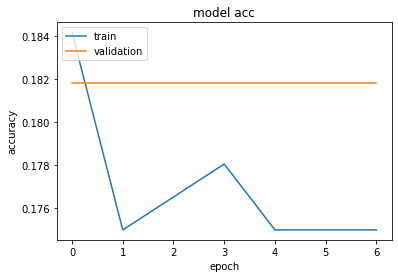

In [27]:
# printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

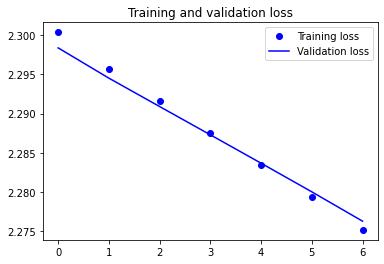

In [28]:
# visualize the loss function of model
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [31]:
# evaluate the model's performance with test data
# this is a dataset the model has never seen before; this is another good check for overfitting
scores = model.evaluate(test_x, test_y, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))
print("Loss = " + str(y_pred[0]))

Accuracy: 18.22%
Loss = [0.0961475  0.10794386 0.10252418 0.1078522  0.10910279 0.09386655
 0.09505761 0.09692644 0.09391245 0.09666646]


In [30]:
# predicting values
y_pred = model.predict(test_x)

22/22 [==============================] - 150s 7s/step


In [36]:
# look at values
for i in y_pred:
    print(i)

[0.0961475  0.10794386 0.10252418 0.1078522  0.10910279 0.09386655
 0.09505761 0.09692644 0.09391245 0.09666646]
[0.09619007 0.10838489 0.10235485 0.10751452 0.10877624 0.09410159
 0.09526902 0.09686358 0.09392279 0.09662245]
[0.09620972 0.10788199 0.10244542 0.10803989 0.10913809 0.09391394
 0.09502465 0.09687536 0.09383199 0.09663893]
[0.09612342 0.10783418 0.10239353 0.10812313 0.10915951 0.09382177
 0.09505828 0.09692156 0.09388395 0.09668065]
[0.09627409 0.10796294 0.10241117 0.10782134 0.10898051 0.09402884
 0.09512824 0.09684353 0.09389438 0.09665495]
[0.09612756 0.10797695 0.10248969 0.10803953 0.10917921 0.09384254
 0.09504272 0.09682445 0.09384247 0.09663486]
[0.09618876 0.10836009 0.1023878  0.10756838 0.10880831 0.0940726
 0.09524186 0.09683824 0.09392359 0.09661033]
[0.09612218 0.10801022 0.10241853 0.10798699 0.10909642 0.09395403
 0.09506386 0.09684517 0.09387323 0.09662931]
[0.09619421 0.10838229 0.10238242 0.10753983 0.10876988 0.0940995
 0.09523921 0.0968703  0.093910

In [34]:
# confusion matrix as another check
confusion_matrix(test_y, y_pred)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [35]:
# plot absolute confucion matrix
skplt.metrics.plot_confusion_matrix(test_y, y_pred)

NameError: name 'skplt' is not defined

In [ ]:
# plot relative confusion matrix
skplt.metrics.plot_confusion_matrix(test_y, y_pred, normalize=True)

In [ ]:
# precision score
precision_score(test_y, y_pred)

In [ ]:
# recall score
recall_score(test_y, y_pred)

In [ ]:
# F1 score
f1_score(test_y, y_pred)

In [ ]:
# Cohen's Kappa score
cohen_kappa_score(test_y, y_pred)

In [ ]:
# precision, recall, fscore, count of each category
precision_recall_fscore_support(test_y, y_pred)

In [ ]:
# ROC Curve value
roc_auc_score(test_y, y_pred)

In [ ]:
# plotting roc curve
fpr, tpr, thresholds = skplt.metrics.roc_curve(test_y, y_pred)  # false positve rate and true positive rate
auc = roc_auc_score(test_y, y_pred)
plt.plot(fpr, tpr, label="ROC Curve, AUC=" + str(auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random chances")
plt.legend(loc=4)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print(auc)

In [ ]:
# look at false positive rate
fpr

In [ ]:
#########################################
# testing own dataset
#########################################

In [1]:
# apply model to own data
img = image.keras.utils.load_img(DATA_PATH_ABS, target_size=(300, 300))

x = image.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print("Input image shape:", x.shape)

my_image = imread(DATA_PATH_ABS)
imshow(my_image)

NameError: name 'image' is not defined